<a href="https://colab.research.google.com/github/SahithyaKedala/SmartStock-Inventory-Optimization-for-Retail-Stores/blob/main/Smart_stock_Milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting and loading the dataset from ZIP...
Loading CSV: ./extracted_data/retail_store_inventory.csv
Dataset columns:
['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality']

First few rows:
         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01       

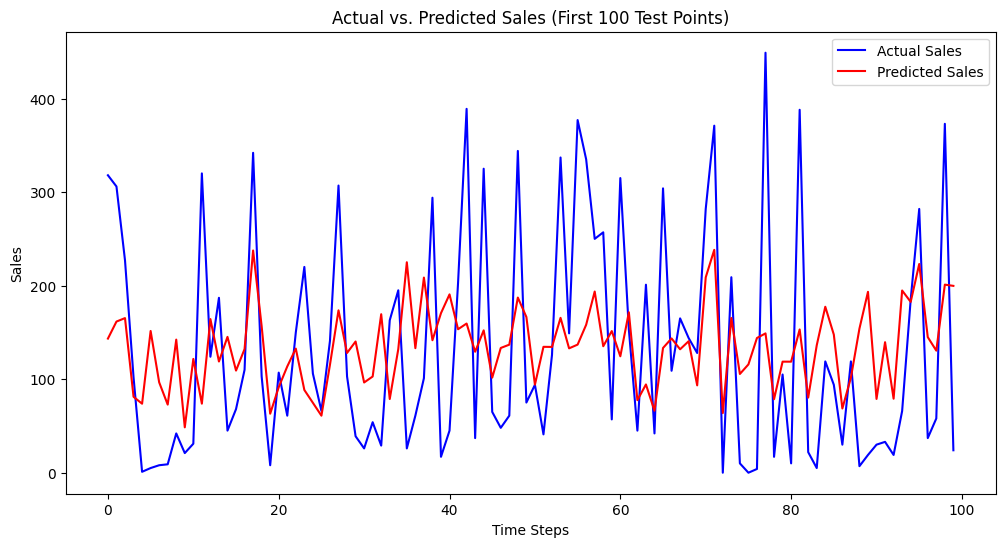

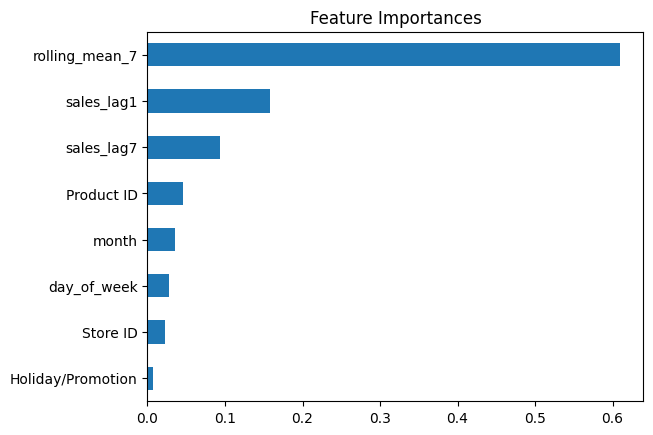

Model training and evaluation complete. If accuracy is poor (e.g., MAE > 20% of mean sales), try adding more features, tuning further, or switching models like ARIMA/Prophet.


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import zipfile
import os
print("Extracting and loading the dataset from ZIP...")
zip_path = '/content/archive (29).zip'
extract_to = './extracted_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

csv_filename = None
for file in os.listdir(extract_to):
    if file.endswith('.csv'):
        csv_filename = file
        break

if csv_filename is None:
    raise FileNotFoundError("No CSV file found in the extracted ZIP. Check the ZIP contents.")

csv_path = os.path.join(extract_to, csv_filename)
print(f"Loading CSV: {csv_path}")

df = pd.read_csv(csv_path)


print("Dataset columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

date_col = 'Date'
store_id_col = 'Store ID'
product_id_col = 'Product ID'
sales_col = 'Units Sold'
inventory_col = 'Inventory Level'
promotion_col = 'Holiday/Promotion'
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col)


df.ffill(inplace=True)

print("Preprocessing the data...")

df['sales_lag1'] = df.groupby([store_id_col, product_id_col])[sales_col].shift(1)
df['sales_lag7'] = df.groupby([store_id_col, product_id_col])[sales_col].shift(7)
df['rolling_mean_7'] = df.groupby([store_id_col, product_id_col])[sales_col].transform(lambda x: x.rolling(7).mean())


df['day_of_week'] = df[date_col].dt.dayofweek
df['month'] = df[date_col].dt.month

df.dropna(inplace=True)


features = ['sales_lag1', 'sales_lag7', 'rolling_mean_7', store_id_col, product_id_col, promotion_col, 'day_of_week', 'month']
target = sales_col


df[store_id_col] = df[store_id_col].astype('category').cat.codes
df[product_id_col] = df[product_id_col].astype('category').cat.codes

if df[promotion_col].dtype == 'bool':
    df[promotion_col] = df[promotion_col].astype(int)

X = df[features]
y = df[target]

print("Splitting the dataset 60:40...")
total_rows = len(df)
train_size = int(0.6 * total_rows)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


print("Training the model...")
model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

best_model.fit(X_train, y_train)

print("Evaluating the model...")
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_sales = y_test.mean()
mae_percentage = (mae / mean_sales) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"MAE as % of Mean Sales: {mae_percentage:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual Sales', color='blue')
plt.plot(y_pred[:100], label='Predicted Sales', color='red')
plt.title('Actual vs. Predicted Sales (First 100 Test Points)')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()

feature_importances = pd.Series(best_model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh', title='Feature Importances')
plt.show()

print("Model training and evaluation complete. If accuracy is poor (e.g., MAE > 20% of mean sales), try adding more features, tuning further, or switching models like ARIMA/Prophet.")